Conda env: `artofproblemsolving`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
import tensorflow as tf

# utils
from utils.utils_for_classification import load_text_dataset_from_directory
# from utils.util import save_pkl
# from utils.util import create_folder
# from utils.util_write_training_result import append_training_result
from utils.util import map_str_label, map_int_label

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def tf_loss(y_actual_list_int, y_pred_list_of_list_proba):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_actual_list_int, y_pred_list_of_list_proba))

def compare_actual_and_predict_values_wpipeline(model, X, y_str, y_int, csv_file_name_path: str): 
    pred_result_int = model.predict(X)
    pred_result_str = [map_int_label[int(i)] for i in pred_result_int]
    
    df_ = pd.DataFrame({
        'text': X,
        'actual': y_str,
        'predicted': pred_result_str,
        'actual_int': y_int,
        'predicted_int': pred_result_int,
    })
    df_ = df_.sort_values(by=['actual'], ascending=True)
    df_.reset_index(inplace=True)

    display(df_.sample(10, random_state=42).sort_values(by=['actual'], ascending=True))
    df_.to_csv(csv_file_name_path, index=False)

def model_evaluate_and_analytics_wpipeline(model, X, y_str, y_int, suptitle: str, cm_file_name_path: str, figsize=(16, 10)): 
    pred_proba_result = model.predict_proba(X)
    pred_result_int = model.predict(X)
    pred_result_str = [map_int_label[int(i)] for i in pred_result_int]
    
    loss = tf_loss(y_int, pred_proba_result)
    
    metricsstr_str = classification_report(y_str, pred_result_str, digits=4)
    metricsint_str = classification_report(y_int, pred_result_int, digits=4)
    
    metrics_dict = classification_report(y_str, pred_result_str, output_dict=True)
    metrics_dict['loss'] = loss
    
    # Plot & save
    class_names_str = ['Algebra', 'Combinatorics', 'Geometry', 'Number Theory']
    class_names_int = [0, 1, 2, 3]
    cm_str = confusion_matrix(y_str, pred_result_str, labels=class_names_str)
    cm_int = confusion_matrix(y_int, pred_result_int, labels=class_names_int)

    figure, ax = plt.subplots(2, 2, figsize=figsize, layout="constrained")
    figure.suptitle(suptitle)

    disp_str = ConfusionMatrixDisplay(confusion_matrix=cm_str, display_labels=class_names_str)
    disp_str.plot(ax=ax[0, 0], cmap='Greens')
    ax[0, 0].set_title('String Labels')

    disp_int = ConfusionMatrixDisplay(confusion_matrix=cm_int, display_labels=class_names_int)
    disp_int.plot(ax=ax[0, 1], cmap='Blues')
    ax[0, 1].set_title('Integer Labels')

    figure.text(0.5, 0.16, metricsstr_str, fontsize=16, ha="right", fontname="Consolas")
    figure.text(0.98, 0.16, metricsint_str, fontsize=16, ha="right", fontname="Consolas")

    figure.text(0.54, 0.12, f"loss: {loss:.4f}", fontsize=16, ha="center", fontname="Consolas")

    figure.delaxes(ax[1, 0])
    figure.delaxes(ax[1, 1])

    plt.savefig(cm_file_name_path)
    plt.show()
    
    return metrics_dict



In [2]:
train_texts, train_str_labels = load_text_dataset_from_directory(r"..\data\classification\train")
train_int_labels = [map_str_label[label] for label in train_str_labels]

test_texts, test_str_labels = load_text_dataset_from_directory(r"..\data\classification\test")
test_int_labels = [map_str_label[label] for label in test_str_labels]


Found 4 labels in "..\data\classification\train"
 - Label "Algebra" 716 files
 - Label "Combinatorics" 658 files
 - Label "Geometry" 802 files
 - Label "Number Theory" 702 files
Total 2878 files
Found 4 labels in "..\data\classification\test"
 - Label "Algebra" 199 files
 - Label "Combinatorics" 183 files
 - Label "Geometry" 223 files
 - Label "Number Theory" 195 files
Total 800 files


In [3]:
param_grid = {
    'model_svc__C': [0.05, 0.1, 0.4, 0.5, 0.6, 1.0, 1.5, 2.0],
    'model_svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'model_svc__gamma': ['scale', 'auto'] + [0.01, 0.1, 0.4, 0.5, 0.6, 1],
    'model_svc__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
    ('model_svc', SVC(probability=True))
])

grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=KFold(n_splits=4, random_state=2024, shuffle=True), 
    n_jobs=-1, 
    verbose=2,
    scoring="f1_macro",
)

start = perf_counter()
grid_search.fit(train_texts, train_int_labels)
end = perf_counter()
print(f"\nTime: {end-start:.2f}s")
print("Done!")


Fitting 4 folds for each of 2560 candidates, totalling 10240 fits

Time: 3880.05s
Done!


```
Fitting 4 folds for each of 2560 candidates, totalling 10240 fits

Time: 3880.05s
Done!
```

In [4]:
print("Best parameters found      :", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
# print("CV result: ", grid_search.cv_results_)
print("Best estimator             :", grid_search.best_estimator_)
print("Best index                 :", grid_search.best_index_)
print("Classes                    :", grid_search.classes_)
print("multimetric_               :", grid_search.multimetric_)
print("refit_time_                :", grid_search.refit_time_)
print("n_splits_                  :", grid_search.n_splits_)
print("n_jobs                     :", grid_search.n_jobs)
print("scorer_                    :", grid_search.scorer_)


Best parameters found      : {'model_svc__C': 1.5, 'model_svc__degree': 1, 'model_svc__gamma': 0.4, 'model_svc__kernel': 'rbf'}
Best cross-validation score: 0.8889255628627212
Best estimator             : Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
                ('model_svc',
                 SVC(C=1.5, degree=1, gamma=0.4, probability=True))])
Best index                 : 1937
Classes                    : [0 1 2 3]
multimetric_               : False
refit_time_                : 5.779707908630371
n_splits_                  : 4
n_jobs                     : -1
scorer_                    : make_scorer(f1_score, response_method='predict', pos_label=None, average=macro)


```
Best parameters found      : {'model_svc__C': 1.5, 'model_svc__degree': 1, 'model_svc__gamma': 0.4, 'model_svc__kernel': 'rbf'}
Best cross-validation score: 0.8889255628627212
Best estimator             : Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
                ('model_svc',
                 SVC(C=1.5, degree=1, gamma=0.4, probability=True))])
Best index                 : 1937
Classes                    : [0 1 2 3]
multimetric_               : False
refit_time_                : 5.779707908630371
n_splits_                  : 4
n_jobs                     : -1
scorer_                    : make_scorer(f1_score, response_method='predict', pos_label=None, average=macro)

```

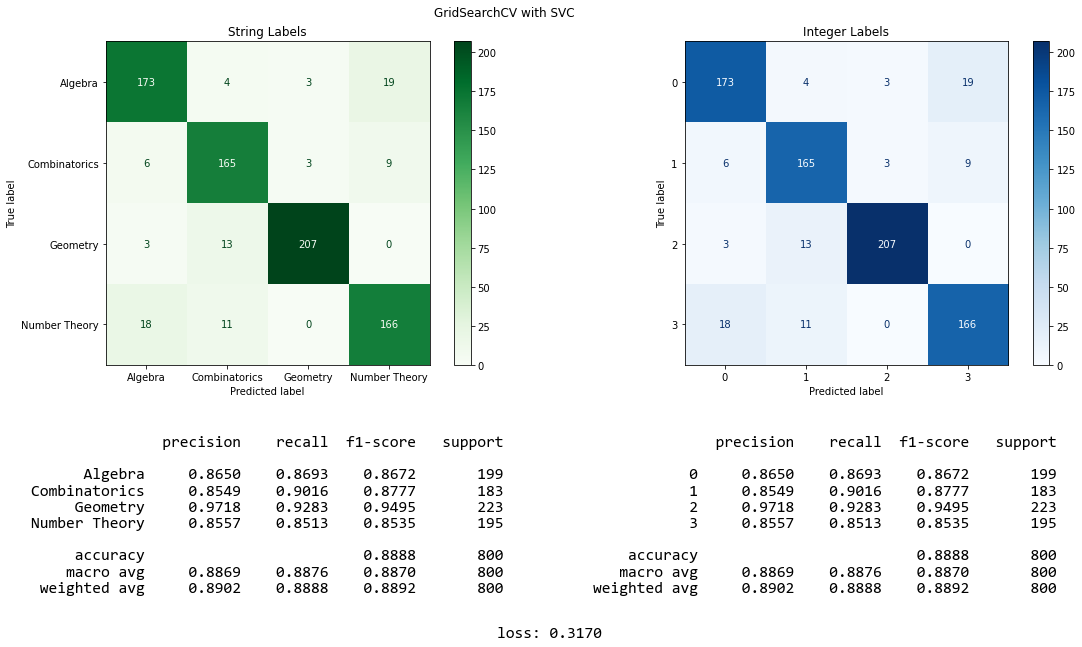

{'Algebra': {'precision': 0.865,
  'recall': 0.8693467336683417,
  'f1-score': 0.8671679197994987,
  'support': 199.0},
 'Combinatorics': {'precision': 0.8549222797927462,
  'recall': 0.9016393442622951,
  'f1-score': 0.8776595744680851,
  'support': 183.0},
 'Geometry': {'precision': 0.971830985915493,
  'recall': 0.9282511210762332,
  'f1-score': 0.9495412844036697,
  'support': 223.0},
 'Number Theory': {'precision': 0.8556701030927835,
  'recall': 0.8512820512820513,
  'f1-score': 0.8534704370179949,
  'support': 195.0},
 'accuracy': 0.88875,
 'macro avg': {'precision': 0.8868558422002557,
  'recall': 0.8876298125722303,
  'f1-score': 0.8869598039223121,
  'support': 800.0},
 'weighted avg': {'precision': 0.8901996964554003,
  'recall': 0.88875,
  'f1-score': 0.889190699760359,
  'support': 800.0},
 'loss': <tf.Tensor: shape=(), dtype=float64, numpy=0.31704911848521755>}

In [6]:
model_evaluate_and_analytics_wpipeline(
    grid_search, 
    test_texts, 
    test_str_labels, 
    test_int_labels, 
    suptitle=f"GridSearchCV with SVC", 
    cm_file_name_path="asdfhiquk1.jpg", 
    figsize=(16, 10)
    )


### 1. Next step, re-train using entire data with best parameters found
### 2. Fit to test data and compare the result with what I've wrote in my bachelor scripte (document)

In [11]:
# {'model_svc__C': 1.5, 'model_svc__degree': 1, 'model_svc__gamma': 0.4, 'model_svc__kernel': 'rbf'}
final_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(lowercase=False)),
    ('model_svc', SVC(kernel='rbf', C=1.5, degree=1, gamma=0.4, probability=True))
])

start = perf_counter()
final_pipeline.fit(train_texts, train_int_labels)
training_time = perf_counter() - start
print(f"Time: {training_time:.2f}s")


Time: 6.02s


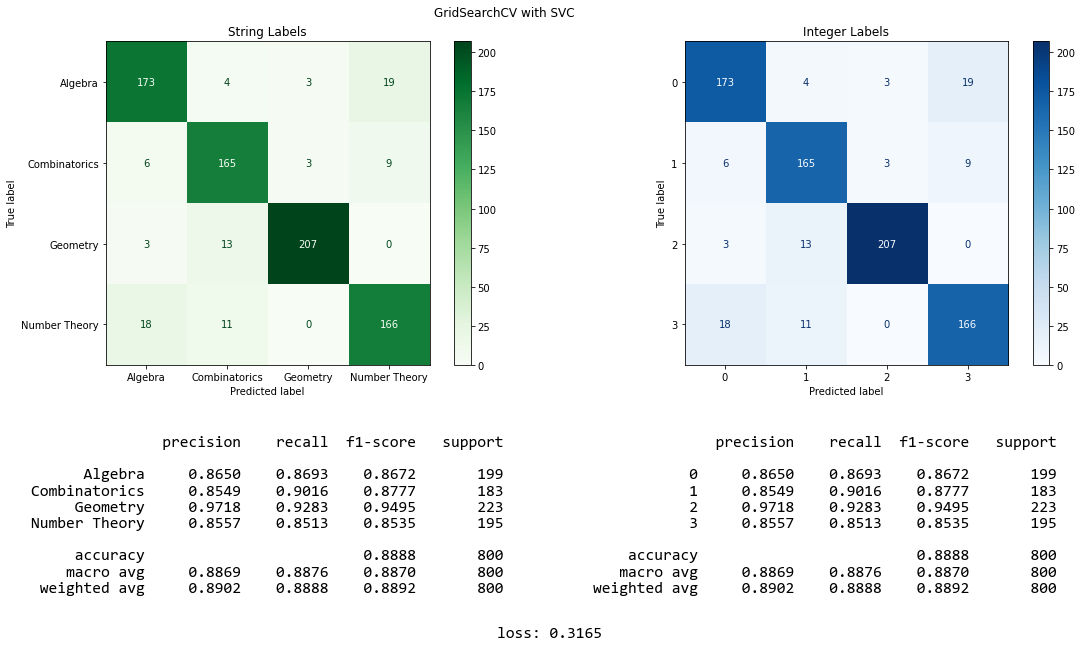

{'Algebra': {'precision': 0.865,
  'recall': 0.8693467336683417,
  'f1-score': 0.8671679197994987,
  'support': 199.0},
 'Combinatorics': {'precision': 0.8549222797927462,
  'recall': 0.9016393442622951,
  'f1-score': 0.8776595744680851,
  'support': 183.0},
 'Geometry': {'precision': 0.971830985915493,
  'recall': 0.9282511210762332,
  'f1-score': 0.9495412844036697,
  'support': 223.0},
 'Number Theory': {'precision': 0.8556701030927835,
  'recall': 0.8512820512820513,
  'f1-score': 0.8534704370179949,
  'support': 195.0},
 'accuracy': 0.88875,
 'macro avg': {'precision': 0.8868558422002557,
  'recall': 0.8876298125722303,
  'f1-score': 0.8869598039223121,
  'support': 800.0},
 'weighted avg': {'precision': 0.8901996964554003,
  'recall': 0.88875,
  'f1-score': 0.889190699760359,
  'support': 800.0},
 'loss': <tf.Tensor: shape=(), dtype=float64, numpy=0.3164810379818639>}

In [12]:
model_evaluate_and_analytics_wpipeline(
    final_pipeline, 
    test_texts, 
    test_str_labels, 
    test_int_labels, 
    suptitle=f"GridSearchCV with SVC", 
    cm_file_name_path="asdfhiquk1.jpg", 
    figsize=(16, 10)
    )
